In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import ray
from ray.rllib.agents import ppo, a3c, dqn, sac

from mdps.cliff import ContextualCliff
from utils.distributions import ConstantDistribution, ParticleDistribution, UniformDistribution

In [2]:
# some utils used later

def prepare_animation(bar_container_, context_history_):
    """Used for animated plotting sampling precedure"""
    def animate(frame_number, data=context_history_):
        # simulate new data coming in
        x = data[frame_number][:, 1]
        n, _ = np.histogram(x, HIST_BINS)
        plt.title(f'{frame_number} posterior mean: {round(x.mean(), 5)}')
        for count, rect in zip(n, bar_container_.patches):
            rect.set_height(count)
        return bar_container_.patches

    return animate


# collect expert rollout

def get_rollouts(solver_, config):
    """Generate rollouts from a given solver and MDP(c)"""
    env_ = ContextualCliff(config=config)
    done_ = False
    obs_ = env_.reset()
    # run until episode ends
    gt_obs_arr_ = obs_
    gt_act_arr_ = None
    gt_rew_arr_ = None
    while not done_:
        action_ = solver_.compute_single_action(obs_)
        obs_, rewawrd_, done_, _ = env_.step(action_)
        gt_obs_arr_ = np.vstack((gt_obs_arr_, obs_))
        if gt_act_arr_ is None:
            gt_act_arr_ = [action_]
            gt_rew_arr_ = [rewawrd_]
        else:
            gt_act_arr_ += [action_]
            gt_rew_arr_ += [rewawrd_]

    gt_act_arr_ = np.array(gt_act_arr_)
    gt_rew_arr_ = np.array(gt_rew_arr_)
    return gt_obs_arr_[1:,:], gt_act_arr_, gt_rew_arr_

def plot_rollouts(gt_obs_arr_, gt_act_arr_):
    """Plot generated rollouts"""
    fig_, ax_1 = plt.subplots()
    fig_.set_size_inches(10, 6, forward=True)

    x = np.arange(start=0, stop=gt_obs_arr_.shape[0])
    ax_2 = ax_1.twinx()
    ax_1.plot(x, gt_obs_arr_[:, 0], 'r-')
    ax_2.plot(x, gt_act_arr_, 'b-', alpha=0.3)

    ax_1.set_xlabel('time step')
    ax_1.set_ylabel('Position (x)', color='r')
    ax_2.set_ylabel('Action', color='b')
    plt.title('sample observations and actions')
    plt.show()

# Contextual "cliff"

This notebook studies using particle filtering to estimate the context parameters of a standard `Cliff` environment in `mdps.cliff`.

The `Cliff` environment has a cart that chooses either to go left or right for a `step_size`. It starts at the `mid_point` of the `right_end` and the `left_end`, and it receives a reward proportional to the power (default set to 2) of its current location, `x`. If it "falls off the cliff" from the left or right end, however, it receives a highly negative reward and the episode ends. Also, there are noise and drift terms, and the state-transition equation of the position `x` is (where `action` is 0 or 1 for moving left or right):
\
$x_{t+1} = N(0, \text{noise}) - \text{drift} * x + 2 * (\text{action}-0.5) * \text{stepsize}$

Thus, the goal of the cart is to keep its position `x` as large as possible (i.e. close to the larger end) and in the meantime keep a distance to that end to prevent accidentally falling off due to the transition noise.

The context params are: `(left_bound, right_bound, pow, step_size, noise, drift)`.

# Set target

We first create a target config, $c$. This will be the $MDP(c)$ the expert uses to generate the observational data.

In [3]:
# true (expert) context: (left_bound, right_bound, pow, step_size, noise, drift) =
#                         [0.0, 2.0, 2.0, 0.05, 0.05, 0.0]
c = {'context_distribution':
         ConstantDistribution(dim=6,
                              constant_vector=np.array([0.0, 2, 2, 0.05, 0.05, 0.0]))}

First, train an expert that masters this context.

## Try different RL algorithms

### 1. ppo

In [4]:
ray.shutdown()
ray.init()
expert = ppo.PPOTrainer(env=ContextualCliff, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(25):
    res = expert.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-05-30 11:20:18,321	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-05-30 11:20:18,321	INFO trainer.py:743 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-05-30 11:20:20,511	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 -91.764874577263
5 62.08520180995162
10 163.90193501304168
15 153.37449993633317
20 172.87536600576732


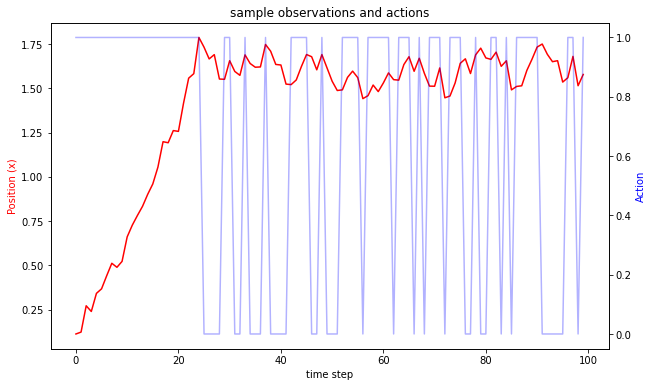

In [29]:
# collect expert rollout
gt_obs_arr, gt_act_arr, _ = get_rollouts(expert, config=c)
plot_rollouts(gt_obs_arr, gt_act_arr)

### 2. a3c

In [57]:
ray.shutdown()
ray.init()
expert_a3c = a3c.A3CTrainer(env=ContextualCliff, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(25):
    res = expert_a3c.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-03-15 21:16:58,470	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
2022-03-15 21:16:58,476	WARNING util.py:57 -- Install gputil for GPU system monitoring.
 pid=65436) 2022-03-15 21:16:58,449	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!


0 -99.98967049924953
5 -54.78545344075454
10 -22.68790286355318
15 -16.127901624432113
20 -12.444555997283794


### 3. dqn

In [58]:
ray.shutdown()
ray.init()
expert_dqn = dqn.DQNTrainer(env=ContextualCliff, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(25):
    res = expert_dqn.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-03-15 21:19:08,660	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 -92.80788991949348
5 -50.57770169947663
10 -28.17314884462317
15 66.84933691192397
20 145.34686428038333


### 4.sac

In [59]:
ray.shutdown()
ray.init()
expert_sac = sac.SACTrainer(env=ContextualCliff, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(25):
    res = expert_sac.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-03-15 21:20:45,417	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 -91.62630750718465
5 -85.87037328636102
10 -80.03772658017724
15 -73.3718669013989
20 -65.31416092048401


In [246]:
gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert, config=c)

In [30]:
r = np.zeros(500)
len = np.zeros(500)
for i in range(500):
    gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert, config=c)
    r[i] = sum(gt_rew_arr)
    len[i] = gt_act_arr.shape[0]
print(np.mean(r))
print(np.mean(len))

162.81253202171098
85.548


2022-05-31 13:38:11,255	WARNING worker.py:1245 -- The node with node id: 167c1ddb9ebf99ac2c73252676ac6217eeae22de40ffd06bdbee7f12 and ip: 127.0.0.1 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a raylet crashes unexpectedly or has lagging heartbeats.
(pid=None) [2022-05-31 13:38:11,268 C 55044 55604] node_manager.cc:809: [Timeout] Exiting because this node manager has mistakenly been marked as dead by the GCS: GCS didn't receive heartbeats from this node for 30000 ms. This is likely because the machine or raylet has become overloaded.
(pid=None) *** StackTrace Information ***
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 


: 

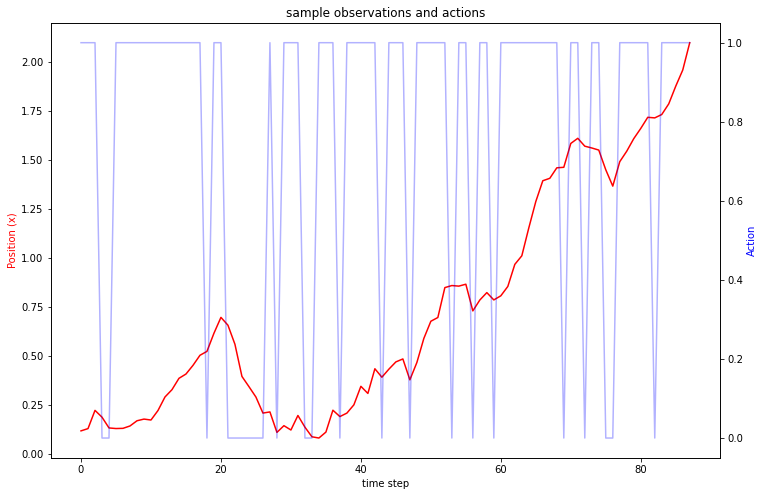

In [245]:
fig, ax_1 = plt.subplots()
fig.set_size_inches(12, 8, forward=True)

x = np.arange(start=0, stop=gt_obs_arr.shape[0])
ax_2 = ax_1.twinx()
ax_1.plot(x, gt_obs_arr[:, 0], 'r-')
ax_2.plot(x, gt_act_arr, 'b-', alpha=0.3)

ax_1.set_xlabel('time step')
ax_1.set_ylabel('Position (x)', color='r')
ax_2.set_ylabel('Action', color='b')
plt.title('sample observations and actions')
# plt.savefig('sac.pdf')
plt.show()

---

In [19]:
np.save("gtobs.npy", gt_obs_arr)
np.save("gtact.npy", gt_act_arr)

In [35]:
gt_act_arr = np.load("gtact.npy")
gt_obs_arr = np.load("gtobs.npy")

## Exact context

We first train a RL solver only on the correct context for particle filtering. We have already done this so we can directly use the expert solver.

In [7]:
# true (expert) context: (left_bound, right_bound, pow, step_size, noise, drift) =
#                       [0.0, 2.0, 2.0, 0.025, 0.05, 0.0]

N = 1000
T = 100
left_bound = np.ones((N,)) * 0.0
pow = np.ones((N,)) * 2
drift = np.random.normal(loc=0.00, scale=0.001, size=(N,))
step_size = np.ones((N,)) * 0.025

In [8]:
def filter_context(solver_,
                   context_distribution_,
                   gt_obs_arr_,
                   T_,
                   N_
                   ):
    state_arr_ = np.zeros((N_,))
    action_arr_ = np.zeros((N_,))
    context_history_ = []
    for t_ in range(T_):
        # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
        qs_ = np.zeros((N_,))
        for n_ in range(N_):
            context_ = context_distribution_.particles[n_]
            c_local_ = {'context_distribution':
                           ConstantDistribution(dim=6,
                                                constant_vector=context_)}
            env_ = ContextualCliff(config=c_local_)
            obs_ = env_.reset()
            if t_ > 0:
                env_.mdp.x = state_arr_[n_]
                obs_ = np.concatenate((np.array([env_.mdp.x]), context_), axis=0).flatten()
            action_ = solver_.compute_single_action(obs_)
            obs_, _, done_, _ = env_.step(action_)
            # estimate likelihood if r >= 1
            if t_ >= 1:
                q = env_.likelihood(gt_obs_arr_[t_ - 1], action_arr_[n_], obs_)
                qs_[n_] = q
            state_arr_[n_] = np.copy(env_.mdp.x)
            action_arr_[n_] = action_
        if t_ >= 1:
            # truncated importance sampling; [https://arxiv.org/pdf/1905.09800.pdf]
            qs_ = np.clip(qs_, 0, np.percentile(qs_, 90))
            qs_ = qs_ / qs_.sum()
            resample_index_ = context_distribution_.resample_particles_from_probability(p=qs_)
            p_temp_ = context_distribution_.particles
            p_noise_ = np.random.normal(loc=0, scale=p_temp_.std(axis=0), size=p_temp_.shape) * 0.05
            context_distribution_.particles += p_noise_
            state_arr_ = state_arr_[resample_index_]
            action_arr_ = action_arr_[resample_index_]
        if t_ % 25 == 0:
            print("round", t_, "posterior mean", context_distribution_.particles[:, 1].mean())
        context_history_ += [context_distribution_.particles.copy()]
    return context_history_, context_distribution_

In [7]:
def multi_round_context(sim_solver_,
                        sim_config_,
                        solver_,
                        context_particles_,
                        T_,
                        N_,
                        n_trajectory_,
                        n_round_,
                        which_param_
                        ):
    context_ = None
    context_mean_ = None
    for i_ in range(n_trajectory_):
        for _ in range(10):
            gt_obs_arr_, _ = get_rollouts(sim_solver_, config=sim_config_)
            if gt_obs_arr_.shape[0] == 100:
                break
        assert gt_obs_arr_.shape[0] == 100
        for j_ in range(n_round_):
            context_distribution_ = ParticleDistribution(
                dim=6, particles=context_particles_, n_particles=N_)
            context_history_, _ = filter_context(solver_,
                                                 context_distribution_,
                                                 gt_obs_arr_,
                                                 T_,
                                                 N_
                                                 )
            context_curr_ = context_history_[-1][:, which_param_]
            if context_ is None:
                context_ = context_curr_
                context_mean_ = [context_curr_.mean()]
            else:
                context_ = np.concatenate((context_, context_curr_))
                context_mean_ += [context_curr_.mean()]
            print("round", (i_ + 1, j_ + 1))
    context_mean_ = np.array(context_mean_)

    return context_, context_mean_

In [8]:
N = 1000
T = 100
left_bound = np.ones((N,)) * 0.0
pow = np.ones((N,)) * 2
drift = np.random.normal(loc=0.00, scale=0.001, size=(N,))
step_size = np.ones((N,)) * 0.025
right_bound = np.random.normal(loc=2.5, scale=0.5, size=(N,))
noise = np.ones((N,)) * 0.05
context_particles = np.abs(np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T)

c = {'context_distribution':
         ConstantDistribution(dim=6,
                              constant_vector=np.array([0.0, 2, 2, 0.05, 0.05, 0.0]))}

context_exact_multi, context_mean_exact_multi = multi_round_context(expert,
                                                                c,
                                                                expert,
                                                                context_particles,
                                                                T,
                                                                N,
                                                                4,
                                                                3,
                                                                1)

round 0 posterior mean 2.4964584083165446
round 25 posterior mean 2.3970673254965225
round 50 posterior mean 2.244819903081753
round 75 posterior mean 2.1563600483232714
round (1, 1)
round 0 posterior mean 2.4964584083165446
round 25 posterior mean 2.5800730686027005
round 50 posterior mean 2.351428712612553
round 75 posterior mean 2.1744480275708504
round (1, 2)
round 0 posterior mean 2.4964584083165446
round 25 posterior mean 2.4806359616403193
round 50 posterior mean 2.3296425489217856
round 75 posterior mean 2.0275676604185287
round (1, 3)
round 0 posterior mean 2.4964584083165446
round 25 posterior mean 2.7368501701766426
round 50 posterior mean 2.5346949023657825
round 75 posterior mean 2.212735596551496
round (2, 1)
round 0 posterior mean 2.4964584083165446
round 25 posterior mean 2.37246109559959
round 50 posterior mean 2.2497923262371398
round 75 posterior mean 2.2043641859968557
round (2, 2)
round 0 posterior mean 2.4964584083165446
round 25 posterior mean 2.419919151749081
r

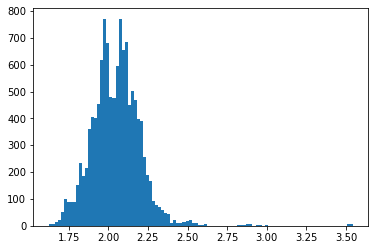

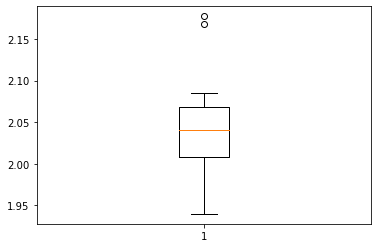

In [10]:
plt.hist(context_exact_multi, bins=100)
plt.show()
plt.boxplot(context_mean_exact_multi)
plt.show()

In [11]:
np.save("context_exact_cliff.npy", context_exact_multi)
np.save("context_mean_exact_cliff.npy", context_mean_exact_multi)

In [19]:
right_bound = np.random.normal(loc=2.5, scale=0.5, size=(N,))
noise = np.ones((N,)) * 0.05

context_particles = np.abs(np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T)
context_distribution = ParticleDistribution(dim=6, particles=context_particles, n_particles=N)

context_history_exact, _ = filter_context(expert,
                                   context_distribution,
                                   gt_obs_arr,
                                   T,
                                   N
                                   )

round 0 posterior mean 2.468266092078936
round 25 posterior mean 2.503267694310116
round 50 posterior mean 2.3131126320445974
round 75 posterior mean 2.0042735627545984


In [20]:
context_history_exact[-1][:, 1].mean()

1.957855446872487

In [ ]:
HIST_BINS = np.linspace(1, 3, 120)

fig, ax = plt.subplots()
plt.axvline(x=2.0, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 2.0'])
_, _, bar_container = ax.hist(context_history_exact[0][:, 1], HIST_BINS, lw=1,
                              ec="cyan", fc="blue", alpha=0.5)
ax.set_ylim(top=N / 4)  # set safe limit to ensure that all data is visible.

ani = animation.FuncAnimation(fig, prepare_animation(bar_container, context_history_exact),
                              len(context_history_exact),
                              repeat=True, blit=False, interval=100, repeat_delay=500)
prior_mean = 2.5
posterior_mean = round(context_history_exact[-1][:, 1].mean(), 3)
ani.save(f'prior_{prior_mean}_posterior{posterior_mean}.mp4', dpi=300)
plt.show()

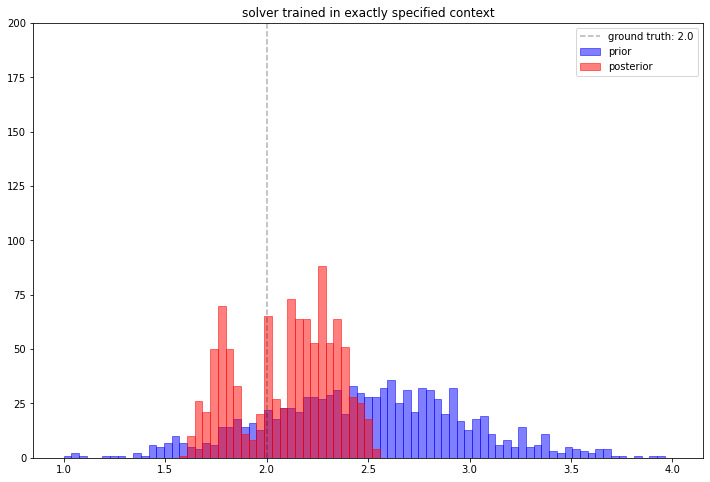

In [10]:
fig, ax = plt.subplots()
HIST_BINS = np.linspace(1, 4, 80)
ax.hist(context_history_exact[0][:, 1], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_exact[-1][:, 1], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=2, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 2.0', 'prior', 'posterior'])
ax.set_ylim(top=N / 5)
fig.set_size_inches(12, 8)
plt.title('solver trained in exactly specified context')
plt.show()

## Misspecified context

In [12]:
# We reduce the right end from 2.0 to 1.5 and keep otherwise the same.
c_mis = {'context_distribution':
             ConstantDistribution(dim=5,
                                  constant_vector=np.array([0.0, 1.5, 2.0, 0.025, 0.05, 0.0]))}

ray.shutdown()
ray.init()
mis_solver = ppo.PPOTrainer(env=ContextualCliff, config={
    "env_config": c_mis,
    "framework": "torch",  # config to pass to env class
})

for eps in range(25):
    res = mis_solver.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])

2022-03-04 13:48:53,403	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 -92.28203492320135
5 -27.125387762276322
10 -16.621934784874732
15 10.349761143125988
20 15.11379922382621


In [ ]:
mis_obs_arr, mis_act_arr = get_rollouts(mis_solver, config=c)
plot_rollouts(mis_obs_arr, mis_act_arr)

In [16]:
N = 1000
T = 100
left_bound = np.ones((N,)) * 0.0
pow = np.ones((N,)) * 2
drift = np.random.normal(loc=0.00, scale=0.001, size=(N,))
step_size = np.ones((N,)) * 0.025
right_bound = np.random.normal(loc=2.5, scale=0.5, size=(N,))
noise = np.ones((N,)) * 0.05
context_particles = np.abs(np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T)

c = {'context_distribution':
         ConstantDistribution(dim=6,
                              constant_vector=np.array([0.0, 2, 2, 0.05, 0.05, 0.0]))}

context_mis_multi, context_mean_mis_multi = multi_round_context(expert,
                                                                c,
                                                                mis_solver,
                                                                context_particles,
                                                                T,
                                                                N,
                                                                4,
                                                                3,
                                                                1)

round 0 posterior mean 2.5029905945585216
round 25 posterior mean 2.5024942190513886
round 50 posterior mean 3.02621769925702
round 75 posterior mean 3.123676816816164
round (1, 1)
round 0 posterior mean 2.5029905945585216
round 25 posterior mean 2.427259675611128
round 50 posterior mean 3.306438321263746
round 75 posterior mean 3.534737146102876
round (1, 2)
round 0 posterior mean 2.5029905945585216
round 25 posterior mean 2.36187628958984
round 50 posterior mean 3.0688376792983543
round 75 posterior mean 3.160317331428365
round (1, 3)
round 0 posterior mean 2.5029905945585216
round 25 posterior mean 2.639822830602586
round 50 posterior mean 3.076732395304567
round 75 posterior mean 3.256380610313123
round (2, 1)
round 0 posterior mean 2.5029905945585216
round 25 posterior mean 2.4920480086065013
round 50 posterior mean 3.087919398790139
round 75 posterior mean 3.3714762956882733
round (2, 2)
round 0 posterior mean 2.5029905945585216
round 25 posterior mean 2.495353150722204
round 50 

In [17]:
np.save("context_mis_cliff.npy", context_mis_multi)
np.save("context_mean_mis_cliff.npy", context_mean_mis_multi)

In [ ]:
# true (expert) context: (left_bound, right_bound, pow, step_size, noise, drift) =
#                       [0.0, 3.0, 2.0, 0.025, 0.05, 0.0]

right_bound = np.random.normal(loc=2.5, scale=0.5, size=(N,))
noise = np.ones((N,)) * 0.05

context_particles = np.abs(np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T)
context_distribution = ParticleDistribution(dim=6, particles=context_particles, n_particles=N)

context_history_mis, _ = filter_context(mis_solver,
                                       context_distribution,
                                       gt_obs_arr,
                                       T,
                                       N
                                       )

In [ ]:
fig, ax = plt.subplots()
HIST_BINS = np.linspace(1, 5, 80)
ax.hist(context_history_mis[0][:, 1], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_mis[-1][:, 1], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=2, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 2.0', 'prior', 'posterior'])
ax.set_ylim(top=N / 5)
fig.set_size_inches(12, 8)
plt.title('solver trained in mis-specified context')
plt.show()

# Uniformly sampled context

We uniformly sample contexts during training, a common way to perform domain randomization.

In [18]:
c_uniform = {'context_distribution':
             UniformDistribution(dim=6,
                              lower_bound_vector=np.array([0.0, 1.0, 2, 0.05, 0.05, 0.0]),
                              upper_bound_vector=np.array([0.0, 3.0, 2, 0.05, 0.05, 0.0]))}

In [19]:
ray.shutdown()
ray.init()
uniform_solver = ppo.PPOTrainer(env=ContextualCliff, config={
                                                    "env_config": c_uniform,
                                                    "framework": "torch",  # config to pass to env class
                                                })

rews = []
for eps in range(25):
    res = uniform_solver.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-03-04 14:12:28,873	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 -83.20486275437773
5 62.46603466824669
10 105.20568426161722
15 151.35321652003893
20 161.4182405746635


In [ ]:
plot_rollouts(*get_rollouts(uniform_solver,
                           config={'context_distribution':
                                    ConstantDistribution(dim=5,
                                    constant_vector=np.array([0.0, 1.5, 2.0, 0.05, 0.05, 0.0]))}))

In [ ]:
plot_rollouts(*get_rollouts(uniform_solver,
                           config={'context_distribution':
                                    ConstantDistribution(dim=5,
                                    constant_vector=np.array([0.0, 2.5, 2.0, 0.05, 0.05, 0.0]))}))

In [20]:
N = 1000
T = 100
left_bound = np.ones((N,)) * 0.0
pow = np.ones((N,)) * 2
drift = np.random.normal(loc=0.00, scale=0.001, size=(N,))
step_size = np.ones((N,)) * 0.025
right_bound = np.random.normal(loc=2.5, scale=0.5, size=(N,))
noise = np.ones((N,)) * 0.05
context_particles = np.abs(np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T)

c = {'context_distribution':
         ConstantDistribution(dim=6,
                              constant_vector=np.array([0.0, 2, 2, 0.05, 0.05, 0.0]))}

context_uniform_multi, context_mean_uniform_multi = multi_round_context(expert,
                                                                c,
                                                                uniform_solver,
                                                                context_particles,
                                                                T,
                                                                N,
                                                                4,
                                                                3,
                                                                1)

round 0 posterior mean 2.4838814350825156
round 25 posterior mean 2.534370841842373
round 50 posterior mean 2.643678567212296
round 75 posterior mean 2.229444461438954
round (1, 1)
round 0 posterior mean 2.4838814350825156
round 25 posterior mean 2.415510966317958
round 50 posterior mean 2.709496684327101
round 75 posterior mean 2.180493386438329
round (1, 2)
round 0 posterior mean 2.4838814350825156
round 25 posterior mean 2.466978019288294
round 50 posterior mean 2.5088229146508176
round 75 posterior mean 2.141364622870386
round (1, 3)
round 0 posterior mean 2.4838814350825156
round 25 posterior mean 2.5599297570437174
round 50 posterior mean 2.2760055768917784
round 75 posterior mean 2.2076870387928915
round (2, 1)
round 0 posterior mean 2.4838814350825156
round 25 posterior mean 2.6769962363948743
round 50 posterior mean 2.5519422419853006
round 75 posterior mean 2.412343258980042
round (2, 2)
round 0 posterior mean 2.4838814350825156
round 25 posterior mean 2.826538976428945
round

In [21]:
np.save("context_uniform_cliff.npy", context_uniform_multi)
np.save("context_mean_uniform_cliff.npy", context_mean_uniform_multi)

In [ ]:
right_bound = np.random.normal(loc=2.5, scale=0.5, size=(N,))
noise = np.ones((N,)) * 0.05

context_particles = np.abs(np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T)
context_distribution = ParticleDistribution(dim=6, particles=context_particles, n_particles=N)

context_history_uniform = filter_context(uniform_solver,
                                           context_distribution,
                                           gt_obs_arr,
                                           T,
                                           N
                                           )

In [ ]:
fig, ax = plt.subplots()
HIST_BINS = np.linspace(1, 4, 80)
ax.hist(context_history_uniform[0][:, 1], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_uniform[-1][:, 1], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=2, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 2.0', 'prior', 'posterior'])
ax.set_ylim(top=N / 5)
fig.set_size_inches(12, 8)
plt.title('solver trained in uniformly sampled context')
plt.show()

# Importance sampling for context

We do training - PF filtering update - training loop.

In [27]:
def multi_round_imp_context(sim_solver_,
                            sim_config_,
                            context_particles_,
                            T_,
                            N_,
                            n_trajectory_,
                            n_round_,
                            which_param_
                            ):
    context_ = None
    context_mean_ = None
    for i_ in range(n_trajectory_):

        for _ in range(10):
            gt_obs_arr_, _ = get_rollouts(sim_solver_, config=sim_config_)
            if gt_obs_arr_.shape[0] == 100:
                break
        
        assert gt_obs_arr_.shape[0] == 100

        for j_ in range(n_round_):
            imp_context_distribution_ = ParticleDistribution(dim=6, particles=context_particles_, n_particles=N_)

            ray.shutdown()
            ray.init()

            imp_solver_ = ppo.PPOTrainer(env=ContextualCliff, config={
                                                            "env_config":  {"context_distribution": imp_context_distribution_},
                                                            "framework": "torch",
                                                        })

            for update_round in range(3):
                # burn in training
                if update_round == 0:
                    for i in range(15):
                        imp_solver_.train()

                context_history_imp_, imp_context_distribution_ = filter_context(imp_solver_,
                                                                                imp_context_distribution_,
                                                                                gt_obs_arr_,
                                                                                T_,
                                                                                N_
                                                                                )

                imp_solver_.workers.foreach_worker(
                            lambda ev: ev.foreach_env(
                                lambda env: env.set_task(imp_context_distribution_)))
                if update_round < 2:
                    for _ in range(5):
                        imp_solver_.train()
            context_curr_ = context_history_imp_[-1][:,which_param_]
            if context_ is None:
                context_ = context_curr_
                context_mean_ = [context_curr_.mean()]
            else:
                context_ = np.concatenate((context_, context_curr_))
                context_mean_ += [context_curr_.mean()]
            print("round", (i_ + 1, j_ + 1))
    context_mean_ = np.array(context_mean_)

    return context_, context_mean_

In [ ]:
N = 1000
T = 100
left_bound = np.ones((N,)) * 0.0
pow = np.ones((N,)) * 2
drift = np.random.normal(loc=0.00, scale=0.001, size=(N,))
step_size = np.ones((N,)) * 0.025
right_bound = np.random.normal(loc=2.5, scale=0.5, size=(N,))
noise = np.ones((N,)) * 0.05
context_particles = np.abs(np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T)

c = {'context_distribution':
         ConstantDistribution(dim=6,
                              constant_vector=np.array([0.0, 2, 2, 0.05, 0.05, 0.0]))}

context_imp_multi, context_mean_imp_multi = multi_round_imp_context(expert,
                                                                c,
                                                                context_particles,
                                                                T,
                                                                N,
                                                                2,
                                                                2,
                                                                1)

In [ ]:
np.save("context_imp_cliff.npy", context_imp_multi)
np.save("context_mean_imp_cliff.npy", context_mean_imp_multi)

2022-02-15 16:03:33,701	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2022-02-15 16:03:34,714	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-02-15 16:03:34,715	INFO trainer.py:745 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-02-15 16:03:36,090	WARNING util.py:57 -- Install gputil for GPU system monitoring.


round 0 posterior mean 2.910317114527295
round 25 posterior mean 3.231093370868455
round 50 posterior mean 3.0246796856279157
round 75 posterior mean 2.268511360021181


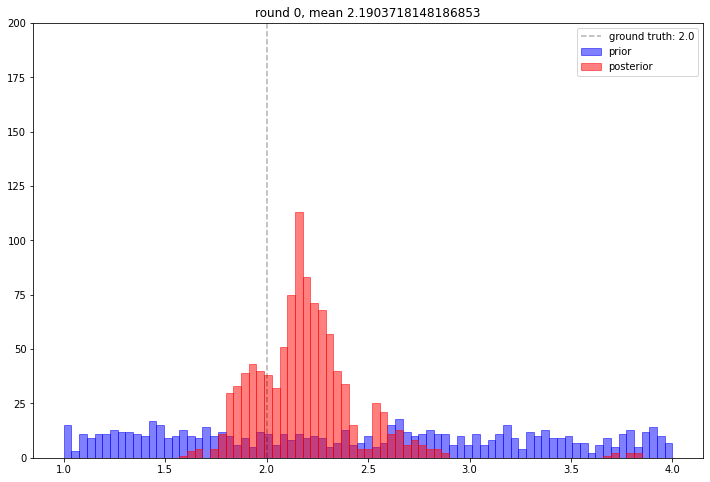

round 0 posterior mean 2.1903718148186853
round 25 posterior mean 2.274505710946588
round 50 posterior mean 2.203005243348516
round 75 posterior mean 2.1668006328212934


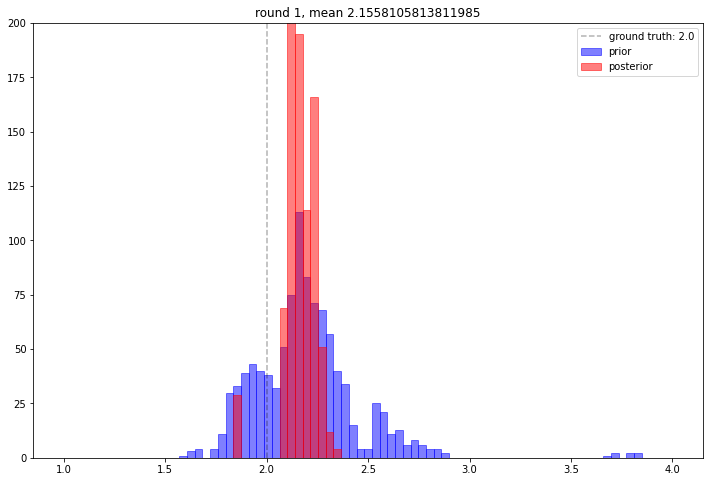

round 0 posterior mean 2.1558105813811985
round 25 posterior mean 2.1515946659641094
round 50 posterior mean 2.1389934013258616
round 75 posterior mean 2.134526022982813


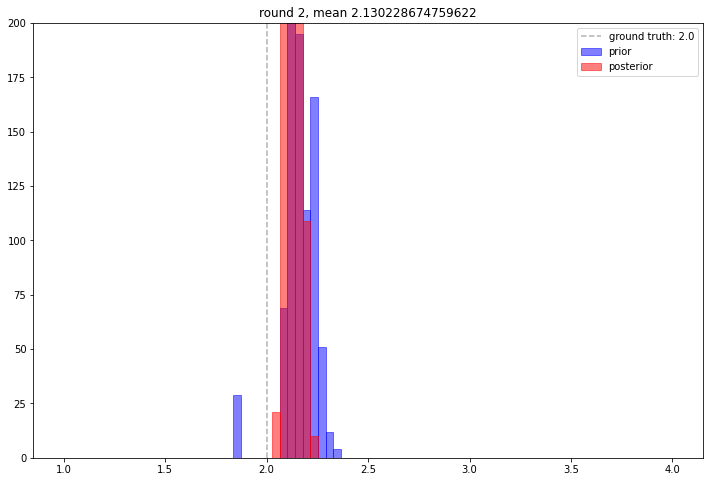

In [6]:
# Initialize uniform prior of right_bound

right_bound = np.random.uniform(1, 5, size=(N,))
noise = np.ones((N,)) * 0.05

prior_context_particles = np.abs(np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T)
imp_context_distribution = ParticleDistribution(dim=6, particles=prior_context_particles, n_particles=N)

ray.shutdown()
ray.init()

# ray.init(address="auto")
imp_solver = ppo.PPOTrainer(env=ContextualCliff, config={
                                                "env_config":  {'context_distribution': imp_context_distribution},
                                                "framework": "torch",  # config to pass to env class
                                            })

for update_round in range(3):
    # burn in training
    if update_round == 0:
        for i in range(15):
            imp_solver.train()

    context_history_imp, imp_context_distribution = filter_context(imp_solver,
                                       imp_context_distribution,
                                       gt_obs_arr,
                                       T,
                                       N
                                       )

    fig, ax = plt.subplots()
    HIST_BINS = np.linspace(1, 4, 80)
    ax.hist(context_history_imp[0][:, 1], HIST_BINS, lw=1,
            ec="blue", fc="blue", alpha=0.5)
    ax.hist(context_history_imp[-1][:, 1], HIST_BINS, lw=1,
            ec="red", fc="red", alpha=0.5)
    plt.axvline(x=2, alpha=0.3, color='black', linestyle='--')
    plt.legend(['ground truth: 2.0', 'prior', 'posterior'])
    ax.set_ylim(top=N / 5)
    fig.set_size_inches(12, 8)
    plt.title(f'round {update_round}, mean {context_history_imp[-1][:, 1].mean()}')
    plt.show()

    imp_solver.workers.foreach_worker(
                lambda ev: ev.foreach_env(
                    lambda env: env.set_task(imp_context_distribution)))
    for _ in range(4):
        imp_solver.train()


In [2]:
context_exact_cliff_data = np.load("context_exact_cliff.npy")
context_mis_cliff_data = np.load("context_mis_cliff.npy")
context_uniform_cliff_data = np.load("context_uniform_cliff.npy")
context_imp_cliff_data = np.load("context_imp_cliff.npy")
context_mean_exact_cliff_data = np.load("context_mean_exact_cliff.npy")
context_mean_mis_cliff_data = np.load("context_mean_mis_cliff.npy")
context_mean_uniform_cliff_data = np.load("context_mean_uniform_cliff.npy")
context_mean_imp_cliff_data = np.load("context_mean_imp_cliff.npy")

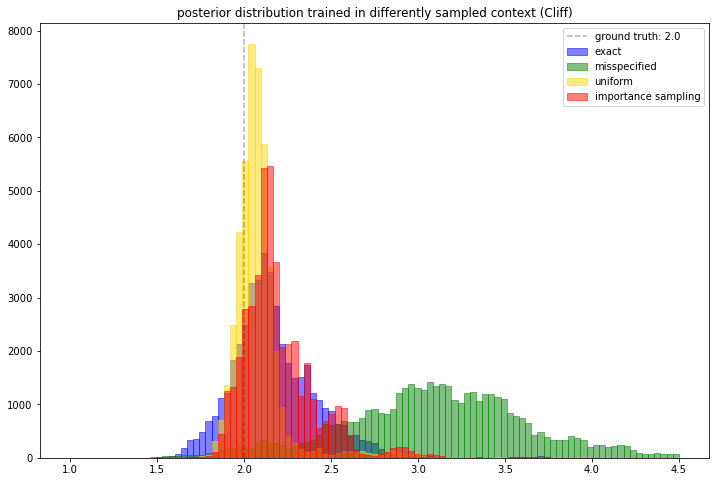

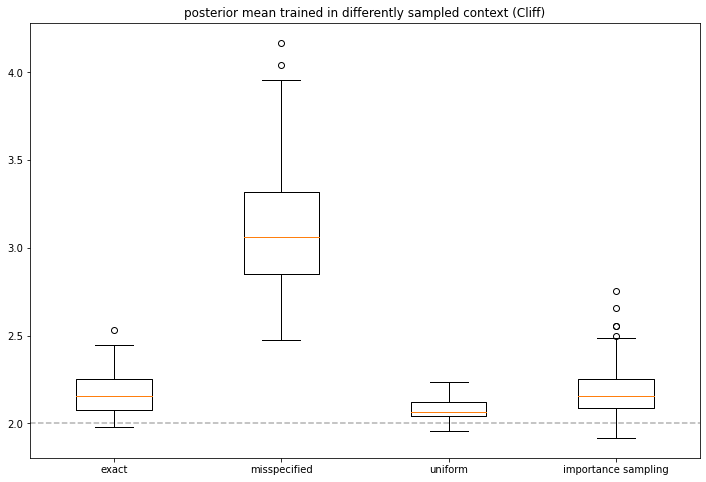

In [17]:
fig, ax = plt.subplots()
HIST_BINS = np.linspace(1.0, 4.5, 100)
ax.hist(context_exact_cliff_data, HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_mis_cliff_data, HIST_BINS, lw=1,
        ec="green", fc="green", alpha=0.5)
ax.hist(context_uniform_cliff_data, HIST_BINS, lw=1,
        ec="gold", fc="gold", alpha=0.5)
ax.hist(context_imp_cliff_data, HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=2.0, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 2.0', 'exact', 'misspecified', 'uniform', 'importance sampling'])
fig.set_size_inches(12, 8)
plt.title('posterior distribution trained in differently sampled context (Cliff)')
plt.show()
# plt.savefig('cliff_hist.pdf') 

res = [context_mean_exact_cliff_data, context_mean_mis_cliff_data, context_mean_uniform_cliff_data, context_mean_imp_cliff_data]
fig, ax = plt.subplots()
ax.boxplot(res, labels=['exact', 'misspecified', 'uniform', 'importance sampling'])
plt.axhline(y=2.0, alpha=0.3, color='black', linestyle='--')
plt.title('posterior mean trained in differently sampled context (Cliff)')
fig.set_size_inches(12, 8)
plt.show()
# plt.savefig('cliff_box.pdf')